# phase_diagram_disorder

> Create a phase diagram of extension vs disorder and initial tension anisotropy, using hard-disk Monte Carlo to create initial conditions with arbitrary amounts of disorder

The Monte-Carlo method and code is taken from https://arxiv.org/abs/2207.07715: event-chain Monte Carlo (ECMC) with straight velocity transfer. In brief, ECMC samples hard-disk configurations by starting with some valid initial condition (e.g. crystalline packing), and moving a disk randomly, until it collides, upon which the velocity is transfered to the disk which was hit. This creates "event chains" which mix the configurations.

In [ ]:
#| default_exp ecmc

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| export

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy import spatial, ndimage

from collections import Counter

from copy import deepcopy
import os
import pickle

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.nn import relu

from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

In [ ]:
#| export

import math
import random

In [ ]:
#| export

from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso);
importlib.reload(drs); importlib.reload(dis);

## Event-chain Monte-Carlo sampling

Three main things done here:
- Create initial condition
- Function to detect disk collisions and collision times
- Main ECMC loop

In [ ]:
#| export

def get_valences(sample,keys=(4, 5, 6, 7, 8)):
    """
    Get proportion of n-sided cells (as specified by keys) from a sample.
    
    sample can be a half-edge mesh or a point cloud, in which case we use the Delaunay triangulation.
    """
    if not isinstance(sample, msh.HalfEdgeMesh):
        tri = spatial.Delaunay(sample)
        mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(tri.points, tri.simplices))
        mesh.remove_obtuse_bdry()
    else:
        mesh = sample
    valence = Counter([len(v.incident) for v in mesh.vertices.values() if not v.is_bdry()])
    valence = {key: round(valence[key]/sum(valence.values()), ndigits=3) for key in keys}
    return valence

In [ ]:
#| export

def get_box(n_x, n_y, eta, shape: str):
    """Get the bounding box for ECMC that matches the initial point configuration"""
    n = n_x * n_y
    sigma = np.sqrt(eta / (n * np.pi))
    if shape == "square":
        aspect_ratio = 1.0
        box = np.array([1.0 / np.sqrt(aspect_ratio), np.sqrt(aspect_ratio)])
    elif shape == "rectangle":
        aspect_ratio = np.sqrt(3.0) / 2.0
        box = np.array([1.0 / np.sqrt(aspect_ratio), np.sqrt(aspect_ratio)])
    else:
        assert shape == "crystal"
        aspect_ratio = np.sqrt(3.0) / 2.0 * n_y / n_x
        box = np.array([1.0 / np.sqrt(aspect_ratio), np.sqrt(aspect_ratio)])    
    return box


def correct_periodic_position(position: Sequence[float], box: Sequence[float]) -> List[float]:
    """
    Return the given position corrected for periodic boundary conditions in the given simulation box.

    Parameters
    ----------
    position : Sequence[float]
        The position vector.
    box : Sequence[float]
        The geometry of the simulation box.

    Returns
    -------
    List[float]
        The position vector after considering periodic boundary condition.
    """
    return [p % b for p, b in zip(position, box)]


def create_crystal(n_x: int, n_y: int, eta: float) -> List[List[float]]:
    """
    Create an initial crystalline hard-disk configuration in the given simulation box so that the disks
    are located on the triangular lattice of a fully packed configuration.

    Parameters
    ----------
    n_x : int
        The number of disks per row in the lattice.
    n_y : int
        The number of rows in the lattice.
    eta : float
        Packing fraction.
    box : Sequence[float]
        The geometry of the box.

    Returns
    -------
    List[List[float]]
        The list of the initial two-dimensional hard-disk positions.

    Raises
    ------
    RuntimeError
        If the n_x * n_y hard disks of radius sigma do not fit in the specified simulation box.
    """
    n = n_x * n_y
    sigma = np.sqrt(eta / (n * np.pi))
    box =  get_box(n_x, n_y, eta,shape="crystal")
    n = n_x * n_y
    pos = [[0.0, 0.0] for _ in range(n)]
    distance_x = box[0] / n_x
    if distance_x < 2 * sigma:
        raise RuntimeError("The specified number of hard disks do not fit into the given simulation box.")
    distance_y = box[1] / n_y
    for i in range(n_y):
        for j in range(n_x):
            pos[i * n_x + j] = correct_periodic_position(
                [distance_x * j + 0.5 * distance_x * (i % 2), i * distance_y], box)
    pos = np.array(pos)
    return pos

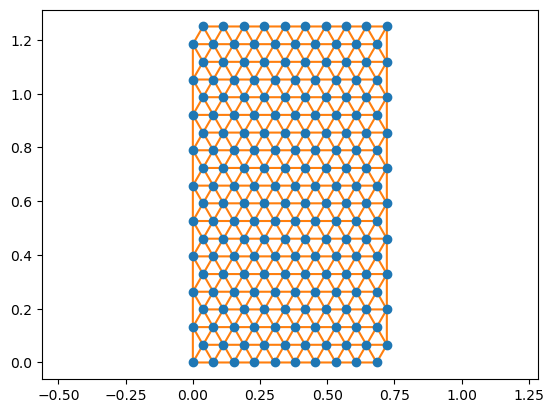

In [ ]:
orientation = "bridge"

box = get_box(10, 20, 0.5, shape="crystal")
pos_orig = create_crystal(10, 20, 0.5)

if orientation == "cable":
    box = box[::-1]
    pos_orig = pos_orig @ dln.rot_mat(np.pi/2)
    pos_orig -= pos_orig.min(axis=0)

spatial.delaunay_plot_2d(spatial.Delaunay(pos_orig));
plt.axis("equal");

In [ ]:
box, pos_orig.max(axis=0)

(array([0.75983569, 1.31607401]), array([0.7218439 , 1.25027031]))

In [ ]:
#| export

def find_all_events(pos, pos_active, direction, sigma, box):
    """
    Compute the times when the active hard disk with a unit velocity in the given direction collides 
    with any other target disk. Also, return the distance between the two disks at the collision.

    This function is vectorized and computes the collision times and distances for all disks at once.
    The collision time is nan if the disks do not collide (the distance is ill-defined in that case).
    
    The collision time of the active disk is a special case as well and might need to be overwritten as well. 

    Parameters
    ----------
    pos : Array of shape (n_disks, 2)
        The positions of the hard disks.
    pos_active : int
        The index of the active position.
    direction : int
        The direction of the unit velocity of the active disk (0 and 1 correspond to a velocities parallel
        to  the x- and y-axes, respectively).
    sigma : float
        The radius of the hard disks.
    box : Sequence[float]
        The geometry of the box.

    Returns
    -------
    time_of_flight: np.array of shape (n_disks,)
        The time of the collision of the disks
    delta_x: np.array of shape (n_disks,)
        the distance of the two disks at the collision.)
    """    
    distance_perp = np.abs(pos[:, 1-direction] - pos[pos_active, 1-direction])
    distance_perp = np.min([distance_perp, box[1-direction] - distance_perp], axis=0)

    distance_para = pos[:, direction]-pos[pos_active, direction]
    distance_para = distance_para + (distance_para<0)*box[direction]
    
    delta_x = np.sqrt(4*sigma**2-distance_perp**2)
    time_of_flight = distance_para - delta_x
    
    # add special cases - can otherwise get stuck in 2-cycles
    time_of_flight[distance_perp >= (2*sigma)] = np.nan
    time_of_flight[distance_para == 0] = np.nan

    #np.nan_to_num(time_of_flight, nan=np.inf, copy=False)
    
    return time_of_flight, delta_x

In [ ]:
#| export

#| export

def run_ecmc(initial_positions, box, eta, n_chains=100, chain_time=100, progress_bar=True):
    """
    Run ECMC mixing on a sample.
    
    The distribution of hard disks is controlled by the packing fraction eta. eta > 7.2 is the solid phase,
    eta < 7.2 is the liquid phase. To get intermediate values of hexagonal order, values between .7 and .55
    are good. 
    
    The duration of the MC mixing is controlled with the n_chains and chain_time parameters (higher=longer).
    
    
    Parameters
    ----------
    initial_positions : np.array of shape (n, 2)
        Initial positions of disks. Must be a valid configuration (I think).
    eta : float
        Packing fraction
    n_chains : int
        Number of event chains
    chain_time : float
        Time for each chain
        
    Returns
    -------
    positions : np.array of shape (n, 2)
        Sample after MCMC mixing
        
    """
    n = initial_positions.shape[0]
    sigma = np.sqrt(eta / (n * np.pi))
    positions = np.copy(initial_positions)
    
    if progress_bar:
        cbar = tqdm(range(n_chains))
        cbar.set_description("Running ECMC to create mesh")
    else: 
        cbar = range(n_chains) 
    for sample in cbar: #(cbar := tqdm(range(n_chains))):
        direction = random.randint(0, 1)
        active = random.randint(0, n - 1)
        current_chain_time = chain_time
        while current_chain_time > 0.0:
            #print(current_chain_time)
            time_of_flight, delta_x = find_all_events(positions, active, direction, sigma, box)
            time_of_flight[active] = current_chain_time
            target = np.nanargmin(time_of_flight)
            event_time, delta_x = (time_of_flight[target], delta_x[target])
            # The event time could be slightly negative due to the rounding error of the trigonometry calculation.
            # If the event time is negative, it is set to 0.0 in order to prevent the active disk moving backwards.
            positions[active, direction] += max(event_time, 0.0)
            if positions[active, direction] > box[direction]:
                positions[active, direction] -= box[direction]
            active = target
            current_chain_time -= event_time
    positions = positions % box
    
    return positions

In [ ]:
## full example

n_x, n_y = (5, 5) # 30, 20
orientation = "cable"

eta = 0.6

# need sufficient amount of mixing to avoid completely degenerate Delaunay triangles, which can cause a hiccup
# in the half-edge mesh data structure initialization.

n_chains, chain_time = (10, 100)

box = get_box(n_x, n_y, eta, shape="crystal")
initial_positions = create_crystal(n_x, n_y, eta)

if orientation == "cable":
    box = box[::-1]
    initial_positions = initial_positions @ dln.rot_mat(np.pi/2)
    initial_positions -= initial_positions.min(axis=0)

In [ ]:
random.seed(18)
final_positions = run_ecmc(initial_positions, box, eta, n_chains=n_chains, chain_time=10)#

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_135473/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


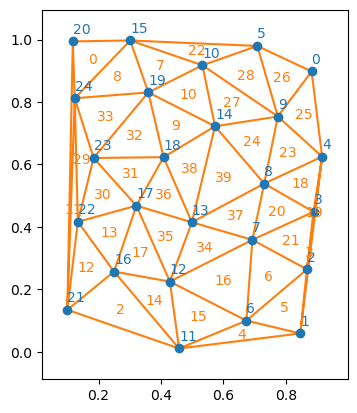

In [ ]:
tri = spatial.Delaunay(final_positions)
premesh = msh.ListOfVerticesAndFaces(tri.points, tri.simplices)

spatial.delaunay_plot_2d(tri);

ax = plt.gca()

for key, val in premesh.vertices.items():
    ax.text(*(val+np.array([0,0.025])), str(key), color="tab:blue")

    
for key, val in premesh.faces.items():
    centroid = np.mean([premesh.vertices[x] for x in val], axis=0)
    ax.text(*centroid, str(key), color="tab:orange", ha="center", va="center")

    
ax.set_aspect("equal", adjustable="box");

In [ ]:
msh.HalfEdgeMesh(premesh)

<CE_simulation.mesh.HalfEdgeMesh>

In [ ]:
#| export

def remove_box_boundary(mesh, dx=1, method="faces"):
    """
    Remove the triangles farther away then dx from the bounding box.
    
    Note: the returned mesh does not have any non-required attributes set, e.g. primal vertex positions.
    Method="faces", "vertices"
    """
    if method == "faces":
        coords = np.stack([x.coords.mean(axis=0) for x in mesh.faces.values()])
    elif method == "vertices":
        coords = np.stack([x.coords for x in mesh.vertices.values()])
    max_x, min_x = (coords[:,0].max(), coords[:,0].min())
    max_y, min_y = (coords[:,1].max(), coords[:,1].min())

    if method == "faces":
        boundary_faces = [key for key, val in mesh.faces.items() if
                          ((val.coords.mean(axis=0)[0] < (min_x+dx)) or (val.coords.mean(axis=0)[0] > (max_x-dx)) or
                           (val.coords.mean(axis=0)[1] < (min_y+dx)) or (val.coords.mean(axis=0)[1] > (max_y-dx)))]
    elif method == "vertices":
        boundary_vertices = [key for key, val in mesh.vertices.items() if
                             ((val.coords[0] < (min_x+dx)) or (val.coords[0] > (max_x-dx)) or
                              (val.coords[1] < (min_y+dx)) or (val.coords[1] > (max_y-dx)))]

    mesh_cleaned = deepcopy(mesh)
    mesh_cleaned = mesh_cleaned.to_ListOfVerticesAndFaces()
    if method == "faces":
        [mesh_cleaned.remove_face(x) for x in boundary_faces]
    elif method == "vertices":
        [mesh_cleaned.remove_vertex(x) for x in boundary_vertices]

    # remove potential orphan vertices
    mesh_cleaned = iso.CellHalfEdgeMesh(mesh_cleaned)
    bad_vertices = [key for key, val in mesh_cleaned.vertices.items() if len(val.incident) < 2]

    mesh_cleaned = mesh_cleaned.to_ListOfVerticesAndFaces()
    [mesh_cleaned.remove_vertex(x) for x in bad_vertices]
    mesh_cleaned = iso.CellHalfEdgeMesh(mesh_cleaned)

    return mesh_cleaned

In [ ]:
#| export

def remove_dangling_triangles(mesh):
    """
    Remove dangling triangles connected to the mesh purely by a single vertex.
    
    Note: the returned mesh does not have any non-required attributes set, e.g. primal vertex positions.
    """
    mesh_cleaned = deepcopy(mesh)
    mesh_cleaned = mesh_cleaned.to_ListOfVerticesAndFaces()
    dangling_faces = [fc for fc in mesh.faces.values() if sum([(he.twin.face is None) for he in fc.hes]) > 2]
    [mesh_cleaned.remove_face(x._fid) for x in dangling_faces]

    return iso.CellHalfEdgeMesh(mesh_cleaned)

In [ ]:
#| export

def create_hard_disk_initial(n_x, n_y, eta, initial_strain, orientation="cable",
                             remove_boundary_dx=1, intercalate=False,
                             noise_gaussian=0, isogonal=0,
                             n_chains=100, chain_time=100, progress_bar=True):
    """
    Create half-edge mesh initial condition with all necessary book-keeping from hard disk sampling.
    
    If you chose the mixing parameters (n_chains, chain_time) too low, degenerate Delaunay triangles
    can appear which mess up the data structure. So don't do that!
    
    Removes a strip of width "remove_boundary_dx" from the box edges to get rid of 
    very degenerate Delaunay triangles at the edge.
    
    noise_gaussian adds Gaussian noise on top to the triangle vertex positions.
    
    Optional: intercalate all edges with negative length. this reduces the tension anisotropy!
    
    """
    # create initial condition for ECMC
    box = get_box(n_x, n_y, eta, shape="crystal")
    initial_positions = create_crystal(n_x, n_y, eta)
    if orientation == "cable":
        box = box[::-1]
        initial_positions = initial_positions @ dln.rot_mat(np.pi/2)
        initial_positions -= initial_positions.min(axis=0)
    # run ECMC
    final_positions = run_ecmc(initial_positions, box, eta, n_chains=n_chains, chain_time=chain_time,
                               progress_bar=progress_bar)
    final_positions -= final_positions.mean(axis=0)

    # stupid step - need to get mesh to compute rescaling factor
    temp_tri = spatial.Delaunay(final_positions)
    temp_mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(temp_tri.points, temp_tri.simplices))
    rescale = 1/np.mean(list(temp_mesh.get_edge_lens().values()))
    final_positions *= rescale
    
    # add gaussian noise - need to do that _before_ computing delaunay or may generate invalid triangulation!
    if noise_gaussian > 0:
        final_positions += np.random.normal(size=final_positions.shape, scale=noise_gaussian)
    
    # convert to mesh and apply initial strain
    tri = spatial.Delaunay(final_positions)
    mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(tri.points, tri.simplices))
    mesh.transform_vertices(dln.shear_mat(1+initial_strain))
    
    # clean the boundary
    mesh = remove_box_boundary(mesh, dx=remove_boundary_dx, method="faces")
    mesh = remove_dangling_triangles(mesh)
    
    # transform to cell mesh and set initial edge lengths and primal coords
    rescale = 1/np.mean(list(mesh.get_edge_lens().values()))
    mesh.transform_vertices(lambda x: rescale*x)
    mesh.set_rest_lengths()
    mesh.set_voronoi()
    
    # intercalate negative edge lengths if desired.
    if intercalate:
        _, _ = mesh.intercalate(exclude=[], minimal_l=0, reoptimize=False)
        mesh.set_voronoi()
        for he in mesh.hes.values():
            he.passive = 0

    # set active and passive faces
    passive_faces = sorted([fc._fid for fc in mesh.faces.values() if fc.is_bdry()])
    passive_edges = list(msh.flatten([[he._heid for he in mesh.faces[fc].hes] for fc in passive_faces]))
    passive_cells = [v._vid for v in mesh.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.faces])]

    property_dict = {"passive_faces": passive_faces, "passive_edges": passive_edges, "passive_cells": passive_cells,
                     "bdry_x": np.max([v.coords[0] for v in mesh.vertices.values()])+1,
                     "bdry_y": np.max([v.coords[1] for v in mesh.vertices.values()])+1}

    # set rest shape. isogonal mode is isotropic by default.
    for v in mesh.vertices.values():
        v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    # set area
    mean_shape = np.mean([v.get_shape_tensor() for v in mesh.vertices.values() if not v.is_bdry()], axis=0)
    scale = (2*np.sqrt(3)) / np.trace(mean_shape)
    mesh.transform_primal_vertices(scale*np.eye(2))

    return mesh, property_dict

In [ ]:
## need to work on the boundaries to ensure more smoothness
## need to add functionality to ensure all edge lengths are initially positive?

In [ ]:
%matplotlib inline

In [ ]:
random.seed(3)

mesh, property_dict = create_hard_disk_initial(n_x=30, n_y=20, eta=0.6, initial_strain=.1,
                                              n_chains=20, remove_boundary_dx=0)

# note that the initial strain we have here is fourth root of anisotropy as measured by fridtjof

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_135473/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
mesh_clean, property_dict = create_hard_disk_initial(n_x=40, n_y=32, eta=0.85, initial_strain=0,
                                                     noise_gaussian=0.075,
                                                     n_chains=10, remove_boundary_dx=.75)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_76877/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


In [ ]:
property_dict["bdry_y"] / property_dict["bdry_x"] # set to 1.5

1.4281158867844164

(-19.02855050610844, 19.02855050610844)

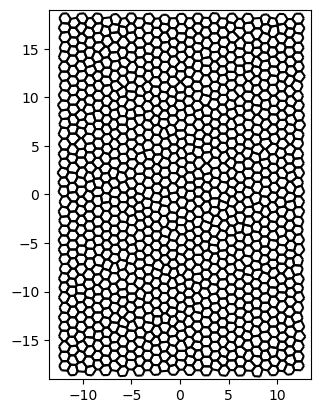

In [ ]:
mesh_clean.cellplot()
#mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");
plt.xlim([-property_dict["bdry_x"]-.5, property_dict["bdry_x"]+.5])
plt.ylim([-property_dict["bdry_y"]-.5, property_dict["bdry_y"]+.5])

(-12.457037557975388, 12.457037557975388)

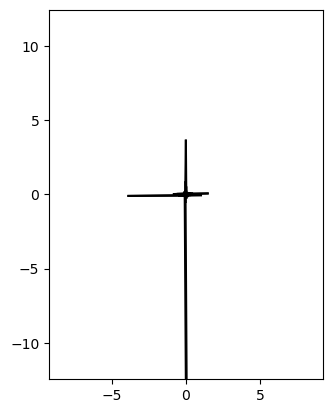

In [ ]:
mesh.cellplot()
#mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");
plt.xlim([-property_dict["bdry_x"]-.5, property_dict["bdry_x"]+.5])
plt.ylim([-property_dict["bdry_y"]-.5, property_dict["bdry_y"]+.5])

In [ ]:
np.mean(np.array(list(mesh_clean.get_primal_edge_lens().values())) < 0)

0.022861356932153392

In [ ]:
mesh_intercalated = deepcopy(mesh_clean)

_, _ = mesh_intercalated.intercalate(exclude=[], minimal_l=0, reoptimize=False)
mesh_intercalated.set_voronoi()

In [ ]:
np.mean(np.array(list(mesh_intercalated.get_primal_edge_lens().values())) < 0)

0.0

(-12.457037557975388, 12.457037557975388)

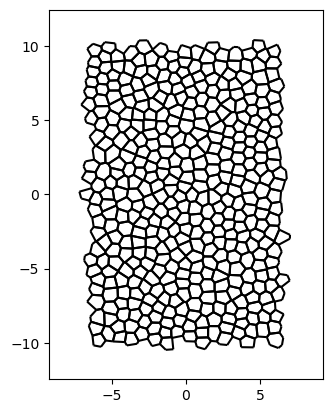

In [ ]:
mesh_intercalated.cellplot()
#mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");
plt.xlim([-property_dict["bdry_x"]-.5, property_dict["bdry_x"]+.5])
plt.ylim([-property_dict["bdry_y"]-.5, property_dict["bdry_y"]+.5])

In [ ]:
stress = np.mean([fc.get_stress_tensor() for fc in mesh_clean.faces.values() if not fc.is_bdry()], axis=0)

stress[1,1] / stress[0,0]

1.3928599309638534

In [ ]:
stress = np.mean([fc.get_stress_tensor() for fc in mesh_intercalated.faces.values() if not fc.is_bdry()], axis=0)
stress[1,1] / stress[0,0]

1.2511439047291713

In [ ]:
np.round((1+np.array([0, 0.012, 0.024, 0.0465, 0.088]))**4-1, decimals=3)

array([0.   , 0.049, 0.1  , 0.199, 0.401])

## create a plot of hexagon percentage vs eta

In [ ]:
#| export

@patch
def get_hexatic_order(self: msh.Vertex, use_tension_vertices=True):
    """
    Get hexatic order parameter, 1/n sum_i exp(i 6 theta_i), as complex number.
    Based on either tension vertex positions or real-space centroids.
    """
    if use_tension_vertices:
        edges = np.stack([he.vertices[0].coords-he.vertices[1].coords for he in self.incident])
    else:
        edges = np.stack([he.vertices[0].get_centroid()-he.vertices[1].get_centroid()
                          for he in self.incident])
    angles = np.stack([tns.vectors_angle(a, b) for a,b in zip(edges, np.roll(edges, 1, axis=0))])
    return np.exp(1j*6*angles).mean()

In [ ]:
#valences = {}
#etas = np.linspace(.5, .7, 20)
#meshes = {}

etas_2 = np.linspace(.5, .9, 5)

chain_time = 200
n_chains = 300

for eta in tqdm(etas_2):
    mesh, property_dict = create_hard_disk_initial(n_x=30, n_y=20, eta=eta, initial_strain=0,
                                                  n_chains=n_chains, chain_time=chain_time)
    meshes[eta] = mesh
    valences[eta] = get_valences(mesh)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_8904/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


KeyboardInterrupt: 

In [ ]:
## make some plots!

In [ ]:
valences[0.8][6]

0.998

[<matplotlib.lines.Line2D>]

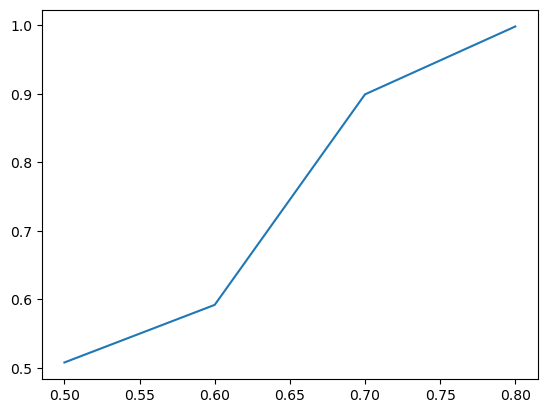

In [ ]:
plt.plot(etas_2[:-1], [valences[key][6] for key in etas_2[:-1]])

[<matplotlib.lines.Line2D>]

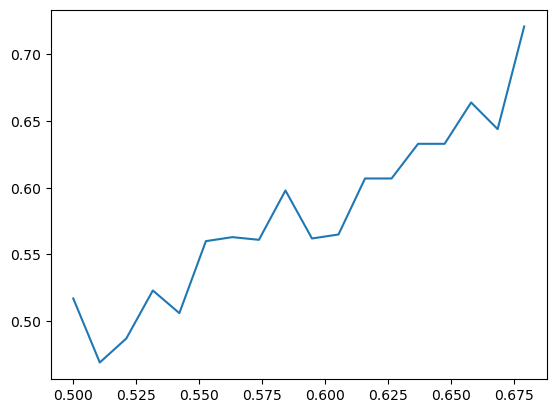

In [ ]:
plt.plot(etas[:-2], [valences[key][6] for key in etas[:-2]])

[<matplotlib.lines.Line2D>]

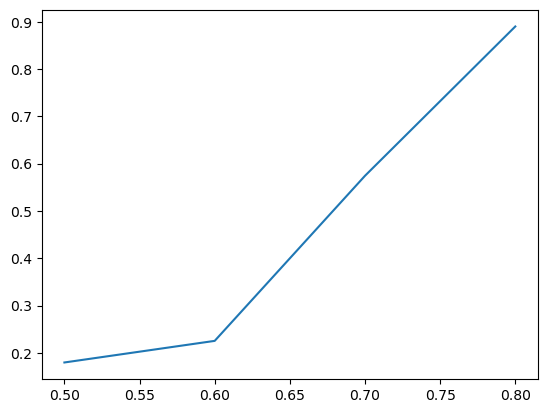

In [ ]:
hexatic = np.stack([np.abs(np.mean([v.get_hexatic_order() for v in meshes[key].vertices.values()]))
                    for key in etas_2[:-1]])

plt.plot(etas_2[:-1], hexatic)

In [ ]:
hexatic

array([0.17955965, 0.22524124, 0.57429004, 0.88997032])

[<matplotlib.lines.Line2D>]

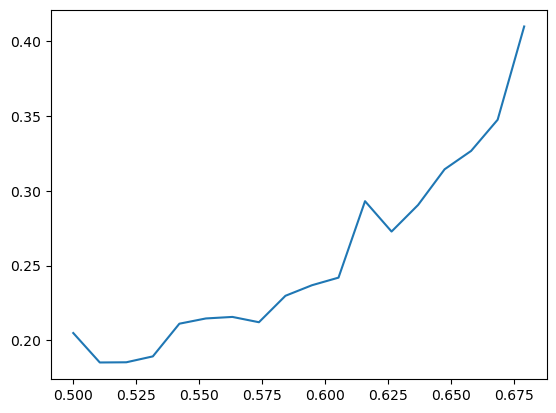

In [ ]:
hexatic = np.stack([np.abs(np.mean([v.get_hexatic_order() for v in meshes[key].vertices.values()]))
                    for key in etas[:-2]])

plt.plot(etas[:-2], hexatic)

### Centerline measurements

Idea:

- get outline using boundary + hull
- distance transform
- fast marching from one end to another

In [ ]:
## create example mesh

mesh, _ = drs.create_rect_initial(50, 20)

mesh_orig = deepcopy(mesh)

#mesh.transform_vertices(lambda x: x+np.array([0, 2*1e-3*x[0]**3]))

mesh.transform_vertices(lambda x: x+np.array([0, 2*1e-3*x[0]**3]))

#mesh.transform_vertices(lambda x: x+np.array([2*1e-3*x[1]**3, 0]))

In [ ]:
len(mesh.vertices)

1000

(-23.33938463199062, 23.33938463199062, -31.18919843802855, 31.18919843802855)

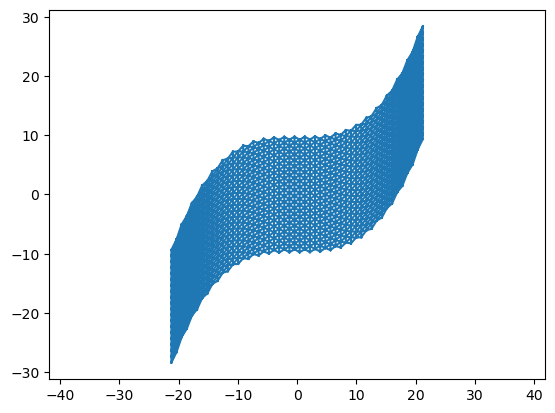

In [ ]:
mesh.triplot()
plt.axis("equal")

In [ ]:
# now turn this into a mask. simplest manner - 

dx = .5


coords = np.stack([v.coords for v in mesh.vertices.values()])

xlims = (coords[:,0].min()-2*dx, coords[:,0].max()+2*dx)
ylims = (coords[:,1].min()-2*dx, coords[:,1].max()+2*dx)

x = np.linspace(xlims[0], xlims[1], round((xlims[1]-xlims[0])/dx))
y = np.linspace(ylims[0], ylims[1], round((ylims[1]-ylims[0])/dx))

X, Y = np.meshgrid(x,y)
r = np.stack([X,Y], axis=-1)

mask = np.zeros_like(X)

for p in coords:
    dist = np.linalg.norm(r-p, axis=-1)
    ind = np.unravel_index(np.argmin(dist), dist.shape)
    mask[-(ind[0]+1), ind[1]] = 1
    
mask = ndimage.binary_dilation(mask, iterations=2)
#mask = ndimage.binary_closing(mask, iterations=3)
#mask = ndimage.binary_fill_holes(mask)

distance_tf = ndimage.distance_transform_edt(mask)
distance_tf = distance_tf.max()-distance_tf

distance_tf_neg = ndimage.distance_transform_edt(1-mask)

distance_tf = distance_tf + distance_tf_neg

In [ ]:
distance_tf_neg.min()

0.0

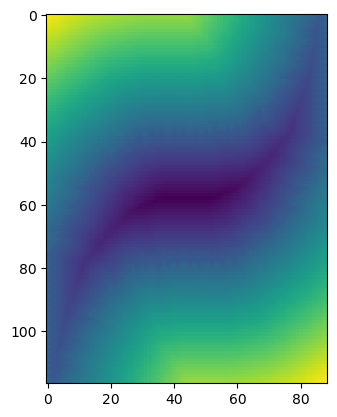

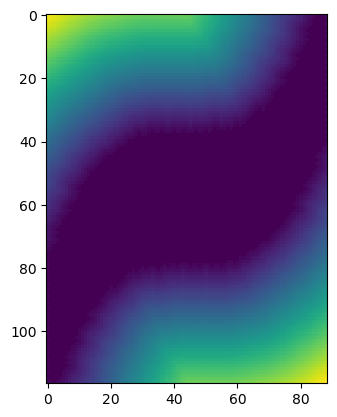

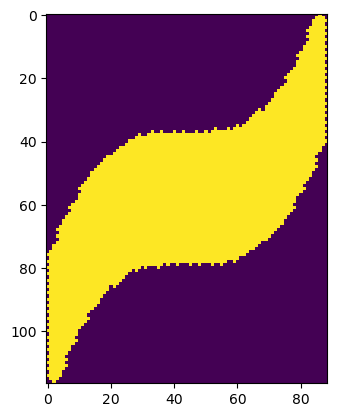

In [ ]:
plt.imshow(distance_tf)
plt.show()

plt.imshow(distance_tf_neg)
plt.show()

plt.imshow(mask)
plt.show()

In [ ]:
## now we just need to find an end and a starting point.
# this has to be done at the initial timepoint!

In [ ]:
coords = np.stack([v.coords for v in mesh_orig.vertices.values()])

max_x, min_x = (coords[:,0].max(), coords[:,0].min())
med_y = np.median(coords[:,1])

min_key, _ = min(mesh_orig.vertices.items(), key=lambda x: np.linalg.norm(x[1].coords-np.array([min_x, med_y]))) 
max_key, _ = min(mesh_orig.vertices.items(), key=lambda x: np.linalg.norm(x[1].coords-np.array([max_x, med_y]))) 

In [ ]:
min_key, max_key

(10, 989)

(-23.33938463199062,
 23.33938463199062,
 -10.725000000000001,
 10.725000000000001)

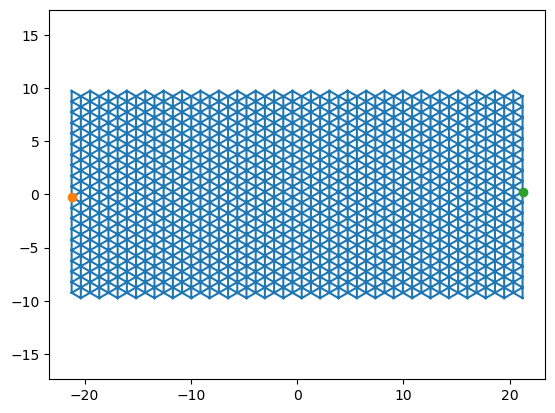

In [ ]:
mesh_orig.triplot()

plt.scatter(*mesh_orig.vertices[min_key].coords, color="tab:orange")
plt.scatter(*mesh_orig.vertices[max_key].coords, color="tab:green")

plt.axis("equal")

(-23.33938463199062, 23.33938463199062, -31.18919843802855, 31.18919843802855)

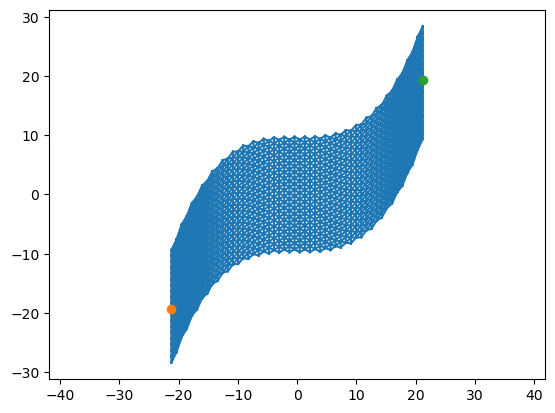

In [ ]:
mesh.triplot()

plt.scatter(*mesh.vertices[min_key].coords, color="tab:orange")
plt.scatter(*mesh.vertices[max_key].coords, color="tab:green")

plt.axis("equal")

In [ ]:
from skimage import graph

In [ ]:
start = np.unravel_index(np.argmin(np.linalg.norm(r-mesh.vertices[min_key].coords, axis=-1)), X.shape)
end = np.unravel_index(np.argmin(np.linalg.norm(r-mesh.vertices[max_key].coords, axis=-1)), X.shape)

path, length = graph.route_through_array(distance_tf**4, (-start[0], start[1]), (-end[0], end[1]))

path_inds = np.stack(path)

path_geom = np.stack([X[path_inds[:,0], path_inds[:,1]], Y[-path_inds[:,0], -path_inds[:,1]]], axis=1)

#path_geom = ndimage.gaussian_filter1d(path_geom, sigma=2, axis=0)[2:-2]

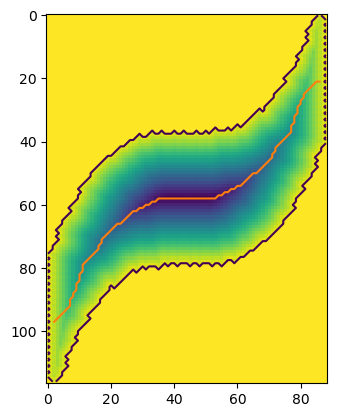

In [ ]:
plt.plot(path_inds[:,1], path_inds[:,0], color="tab:orange")


plt.imshow(distance_tf)

plt.contour(mask)
plt.show()


(-23.33938463199062, 23.33938463199062, -31.18919843802855, 31.18919843802855)

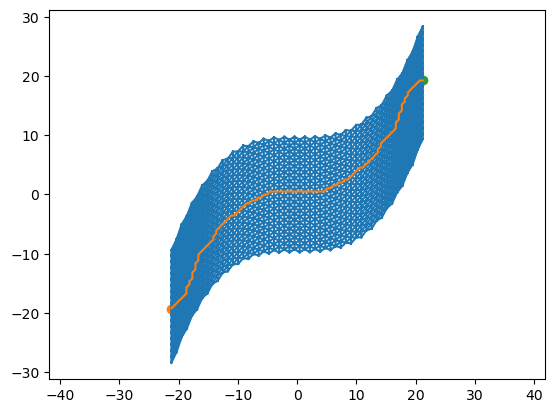

In [ ]:
plt.plot(path_geom[:,0], path_geom[:,1], color="tab:orange")

plt.scatter(*mesh.vertices[min_key].coords, color="tab:orange")
plt.scatter(*mesh.vertices[max_key].coords, color="tab:green")


mesh.triplot()
plt.axis("equal")

In [ ]:
# now we would also like to get the width. To do this, we select the top and bottom boundary 
# and find the distance to the centerline


coords = np.stack([v.coords for v in mesh_orig.vertices.values()])

max_y, min_y = (coords[:,1].max(), coords[:,1].min())
tol = 1
top_bdry = [v._vid for v in mesh_orig.vertices.values() if v.is_bdry() and np.abs(v.coords[1]-max_y) < tol]
bottom_bdry = [v._vid for v in mesh_orig.vertices.values() if v.is_bdry() and np.abs(v.coords[1]-min_y) < tol]

(-23.33938463199062, 23.33938463199062, -31.18919843802855, 31.18919843802855)

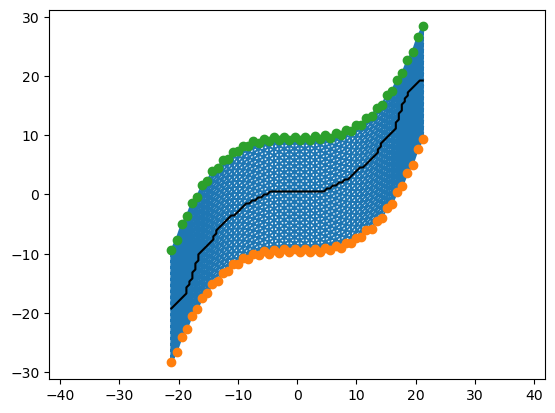

In [ ]:
mesh.triplot()

for p in top_bdry:
    plt.scatter(*mesh.vertices[p].coords, color="tab:green")

for p in bottom_bdry:
    plt.scatter(*mesh.vertices[p].coords, color="tab:orange")

    
plt.plot(path_geom[:,0], path_geom[:,1], color="k")

plt.axis("equal")

In [ ]:
# measure the width now

top_dist = [np.linalg.norm(path_geom-mesh.vertices[v].coords, axis=1).min() for v in top_bdry]
bottom_dist = [np.linalg.norm(path_geom-mesh.vertices[v].coords, axis=1).min() for v in bottom_bdry]

dist_all = np.array(top_dist+bottom_dist)

np.mean(dist_all), np.median(dist_all) # let's use the median

(7.142199312004214, 7.830041502937401)

In [ ]:
# no centerline needed really

bottom_coords = np.stack([mesh.vertices[v].coords for v in bottom_bdry])
top_bottom_dist = np.array([np.linalg.norm(bottom_coords-mesh.vertices[v].coords, axis=-1).min() for v in top_bdry])
    
np.mean(top_bottom_dist)/2, np.median(top_bottom_dist)/2 # let's use the median

(7.312054946924471, 7.504635998701888)

In [ ]:
top_dist = [np.linalg.norm(path_geom-mesh_orig.vertices[v].coords, axis=1).min() for v in top_bdry]
bottom_dist = [np.linalg.norm(path_geom-mesh_orig.vertices[v].coords, axis=1).min() for v in bottom_bdry]

dist_all = np.array(top_dist+bottom_dist)

np.mean(dist_all), np.median(dist_all) # let's use the median

(8.341228983140859, 9.244588437634455)

In [ ]:
bottom_coords = np.stack([mesh_orig.vertices[v].coords for v in bottom_bdry])
top_bottom_dist = np.array([np.linalg.norm(bottom_coords-mesh_orig.vertices[v].coords, axis=-1).min()
                            for v in top_bdry])
    
np.mean(top_bottom_dist)/2, np.median(top_bottom_dist)/2 # let's use the median

(9.380064794363033, 9.380064794363033)

In [ ]:
10.1/9.4, 8.5/7.5

(1.0744680851063828, 1.1333333333333333)

In [ ]:
#| export

from skimage import graph

def get_left_right_pt(mesh):
    """Use initial mesh to get starting points for centerline construction"""
    #coords = np.stack([v.get_centroid() for v in mesh.vertices.values()])
    coords = np.stack([v.coords for v in mesh.vertices.values()]) # use triangle coords

    max_x, min_x = (coords[:,0].max(), coords[:,0].min())
    med_y = np.median(coords[:,1])

    min_key, _ = min(mesh.vertices.items(), key=lambda x: np.linalg.norm(x[1].coords-np.array([min_x, med_y])))
    max_key, _ = min(mesh.vertices.items(), key=lambda x: np.linalg.norm(x[1].coords-np.array([max_x, med_y])))
    
    return min_key, max_key


def get_top_bottom_bdry(mesh, tol=1):
    """Use initial mesh to get top/bottom boundary to measure height with centerline"""
    #coords = np.stack([v.get_centroid() for v in mesh.vertices.values()])
    coords = np.stack([v.coords for v in mesh.vertices.values()]) # use triangle coords
    
    max_y, min_y = (coords[:,1].max(), coords[:,1].min())
    
    top_bdry = [v._vid for v in mesh.vertices.values() if v.is_bdry() and np.abs(v.coords[1]-max_y) < tol]
    bottom_bdry = [v._vid for v in mesh.vertices.values() if v.is_bdry() and np.abs(v.coords[1]-min_y) < tol]

    return top_bdry, bottom_bdry


def get_centerline(mesh, start, stop, dx=.5, sigma=2):
    """Use Noah's fast-marching method to get a centerline"""
    
    # create a coordinate grid array.
    coords = np.stack([v.get_centroid() for v in mesh.vertices.values()])

    xlims = (coords[:,0].min()-2*dx, coords[:,0].max()+2*dx)
    ylims = (coords[:,1].min()-2*dx, coords[:,1].max()+2*dx)

    x = np.linspace(xlims[0], xlims[1], round((xlims[1]-xlims[0])/dx))
    y = np.linspace(ylims[0], ylims[1], round((ylims[1]-ylims[0])/dx))
    X, Y = np.meshgrid(x,y)
    r = np.stack([X,Y], axis=-1)

    # now create a binary mask indicating the location of the mesh
    # by setting pixel at vertex positiions to one and dilating.
    
    mask = np.zeros_like(X)
    for p in coords:
        dist = np.linalg.norm(r-p, axis=-1)
        ind = np.unravel_index(np.argmin(dist), dist.shape)
        mask[-(ind[0]+1), ind[1]] = 1
    mask = ndimage.binary_dilation(mask, iterations=2)
    mask = ndimage.binary_closing(mask, iterations=3)
    mask = ndimage.binary_fill_holes(mask)

    # compute the distance transform
    distance_tf = ndimage.distance_transform_edt(mask)
    distance_tf = distance_tf.max()-distance_tf
    distance_tf_neg = ndimage.distance_transform_edt(1-mask)
    distance_tf = distance_tf + distance_tf_neg    
    
    # now use fastest path finding
    start = np.unravel_index(np.argmin(np.linalg.norm(r-mesh.vertices[start].get_centroid(), axis=-1)), X.shape)
    end = np.unravel_index(np.argmin(np.linalg.norm(r-mesh.vertices[stop].get_centroid(), axis=-1)), X.shape)
    
    path, length = graph.route_through_array(distance_tf**2, (-start[0], start[1]), (-end[0], end[1]))
    path = np.stack(path)
    path_geom = np.stack([X[path[:,0], path[:,1]], Y[-path[:,0], path[:,1]]], axis=1)
    path_geom = ndimage.gaussian_filter1d(path_geom, sigma=sigma, axis=0) #[sigma:-sigma]
    
    return path_geom

def get_arclen(path):
    """compute arc length of path (n, dim) array"""
    return np.sum(np.linalg.norm(path[1:]-path[:-1], axis=1), axis=0)


def get_width(mesh, top_bdry, bottom_bdry):
    """No need a priori for the center line"""
    bottom_coords = np.stack([mesh.vertices[v].get_centroid() for v in bottom_bdry])
    top_bottom_dist = np.array([np.linalg.norm(bottom_coords-mesh.vertices[v].get_centroid(), axis=-1).min()
                                for v in top_bdry])
    return np.median(top_bottom_dist)

def get_width_centerline(mesh, top_bdry, bottom_bdry, centerline):
    """No need a priori for the center line"""
    top_dist = [np.linalg.norm(path_geom-mesh.vertices[v].get_centroid(), axis=1).min() for v in top_bdry]
    bottom_dist = [np.linalg.norm(path_geom-mesh.vertices[v].get_centroid(), axis=1).min() for v in bottom_bdry]

    return 2*np.median(top_dist+bottom_dist)

In [ ]:
%%time 

start, stop = get_left_right_pt(mesh_orig)
top_bdry, bottom_bdry = get_top_bottom_bdry(mesh_orig)

centerline = get_centerline(mesh, start, stop, dx=1, sigma=1)
centerline_orig = get_centerline(mesh_orig, start, stop, dx=1, sigma=1)


length = get_arclen(centerline)
width = get_width(mesh, top_bdry, bottom_bdry)


length_orig = get_arclen(centerline_orig)
width_orig = get_width(mesh_orig, top_bdry, bottom_bdry)

length, width, length_orig, width_orig

CPU times: user 69.8 ms, sys: 0 ns, total: 69.8 ms
Wall time: 69.6 ms


(58.595186086902835, 15.009271997403776, 40.45652119206816, 18.760129588726066)

In [ ]:
(57.92312033417209, 15.009271997403776, 40.256537927290125, 18.760129588726066)

(57.92312033417209, 15.009271997403776, 40.256537927290125, 18.760129588726066)

In [ ]:
length*width / (length_orig*width_orig)

1.158769875073714

In [ ]:
sum(mesh_orig.get_tri_areas().values()), sum(mesh.get_tri_areas().values())

(-806.2696509233365, -806.2696509233355)

(-23.33938463199062, 23.33938463199062, -31.18919843802855, 31.18919843802855)

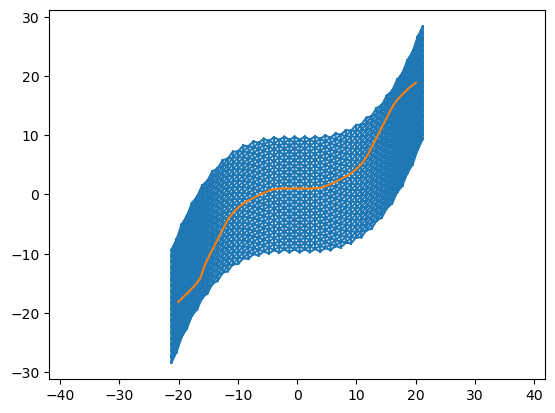

In [ ]:
plt.plot(centerline[:,0], centerline[:,1], color="tab:orange")


mesh.triplot()
plt.axis("equal")

In [ ]:
get_arclen(centerline), get_arclen(centerline_orig)

(58.34104540598613, 42.83030912910996)

### graph based measurement

we could also just use a graph distance and something like `nx`. Unfortunately poor performance for lattice-like configs due to the "Manhattan" effect.

In [ ]:
import networkx as nx

In [ ]:
## convert a mesh to a graph

G = nx.Graph()    
    
for he in mesh_orig.hes.values():
    vs = he.vertices
    G.add_edge(vs[0]._vid, vs[1]._vid, length=np.linalg.norm(vs[0].coords-vs[1].coords))

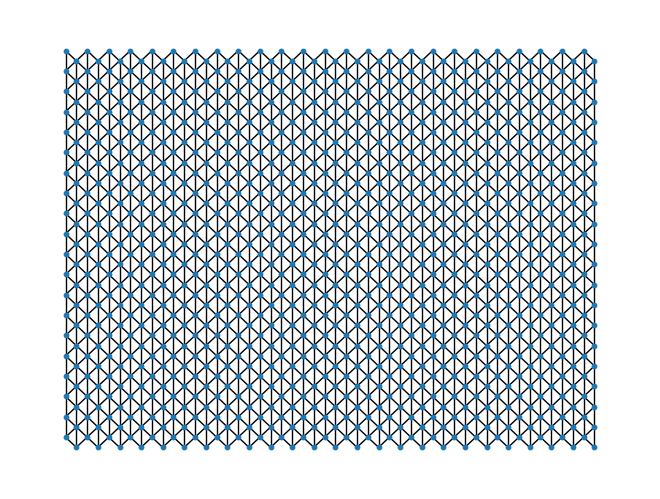

In [ ]:
nx.draw(G, {key: v.coords for key, v in mesh_orig.vertices.items()}, with_labels=False, node_size=10)

In [ ]:
path = nx.shortest_path(G, min_key, max_key, weight=length)

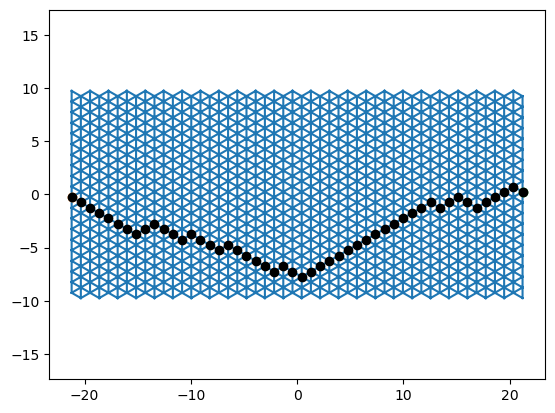

In [ ]:
mesh_orig.triplot()

plt.scatter(*mesh_orig.vertices[min_key].coords, color="tab:orange")
plt.scatter(*mesh_orig.vertices[max_key].coords, color="tab:green")

for p in path:
    plt.scatter(*mesh_orig.vertices[p].coords, color="k")

plt.axis("equal");

# Run simulation

Recall that we have a factor of $15/100$ to convert from simulation steps (with $dt=0.005$) to real time. So lets run say 300 steps. We should probably evaluate at 200 steps, i.e. 30 min.

### Set parameters

In [ ]:
# fixed initial condition parameters: cell number, aspect ratio, elastic energy

n_x = 30 # 30
n_y = 20 # 20

chain_time = 200
n_chains = 30 # 300, now low for test

# feedback parameters

m = 4
k = .5
k_cutoff = .2 # regularization term to cut off excitable feedback

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .005 # time step
forbid_reflip = 20
minimal_l = .05 # minimal edge length, lower edge lengths trigger T1. maybe even lower?
tri_mod_area = .01 # triangle area regularization

# elastic energy parameters

tol, maxiter = (1e-4, 500000) # tol = 1e-4
mod_bulk = 1
mod_shear = 1
angle_penalty = 1000
bdry_penalty = 0 # we don't have a boundary

epsilon_l = (1e-4, 1e-4)  # mollifying parameters to ensure energy differentiability

A0 = jnp.sqrt(3)/2 # no area-perimeter elasticity - we use the shape tensor energy
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # avoid problems at boundary

rel_elastic_modulus = 0 # we have no passive cells
cell_id_to_modulus = lambda x: 1  #np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

def rhs_rest_shape(v): # no rest shape relaxation, since we have no passive cells
    return 0

# package all into a single dict to pass to the optimizer method

energy_args = {'mod_bulk': mod_bulk, 'mod_shear': mod_shear,
               'angle_penalty': angle_penalty, 'bdry_penalty': bdry_penalty, 'epsilon_l': epsilon_l,
               'A0': A0, 'mod_area': mod_area, 'P0': P0, 'mod_perimeter': mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

### Define local function for simulation

To do full simulations, we define a local function. This way, we can use joblib for parallelization.

In [ ]:
def run_phase_diagm_sim(initial_strain, eta, n_steps, run_id=0, save=True, keep_in_memory=True):
    """
    Local function to run simulation in parallel.
    
    run_id can be used to additionally label the folder for saving, in case multiple simulations are run
    for the same parameter values.
    """
    
    # create initial condition
    #print(f"Creating initial condition for eta={eta}, anisotropy={initial_strain}, run_id={run_id}\n")
    print("")
    mesh_initial, property_dict = create_hard_disk_initial(n_x=n_x, n_y=n_y, eta=eta, initial_strain=initial_strain,
                                                           n_chains=n_chains, chain_time=chain_time)
    passive_ids, passive_cells = (property_dict['passive_faces'], property_dict['passive_cells'])
    
    #make_lengths_nonzero(mesh_initial)
    
    def params_pattern(fid):
        if fid in passive_ids:
            return {"k": k, "m": 1} # tension relaxation rate in passive region
        return {"k": k, "m": m, "k_cutoff": k_cutoff}
    
    times = [0]; last_flipped_edges = [[]]
    
    # define directiory for saving stuff, save "metadata"
    save_dir = f"runs/hard_disks/hard_disk_eta_{eta}_anisotropy_{initial_strain}_id_{run_id}"
    if save:
        try:
            os.mkdir(save_dir)
        except FileExistsError:
            print('Warning: directory exists')
        drs.save_self(save_dir, fname="09_phase_diagram_disorder.ipynb")
        with open(f'{save_dir}/property_dict.pickle', 'wb') as handle:
            pickle.dump(property_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    # main simulation loop
    mesh = mesh_initial
    mesh_previous = deepcopy(mesh)
    if keep_in_memory:
        meshes = [mesh_previous]
    cbar = tqdm(range(n_steps))
    cbar.set_description(f"Simulation loop for eta={eta}, anisotropy={initial_strain}, run_id={run_id}")
    for i in cbar:
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass_perimeter, params=params_pattern,
                        rhs_rest_shape=rhs_rest_shape)
        # flatten triangulation
        mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
        # primal optimization
        if use_voronoi:
            mesh.set_voronoi()
        else:
            mesh.optimize_cell_shape(**optimizer_args)
        # check for intercalation
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False,
                                                optimizer_args=optimizer_args)
        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        if save:
            mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=False) # can set that to false.
        if keep_in_memory:
            meshes.append(mesh_previous)

    # save list of T1s for convenience
    last_flipped_edges.append([])
    if save:
        with open(f'{save_dir}/last_flipped_edges.pickle', 'wb') as handle:
            pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)
    if keep_in_memory:
        return meshes, last_flipped_edges
    return (mesh_previous, mesh), last_flipped_edges

### run the simulation loop!

In [ ]:
strains = np.array([0, 0.012, 0.024, 0.0465, 0.088])
# corresponds to Fridtjof anisotropy 0, 5%, 10%, 20%, 40%

etas = np.array([0.5, 0.6, 0.7, 0.8, 0.9]) # to start with.

In [ ]:
n_steps = 300 # 300
eta = 0.6
initial_strain = 0.0465

In [ ]:
# 5 mins for initial cond. creation, 43 min. for simulation loop. So < 1h per simulation.

In [ ]:
meshes_simulated, last_flipped_edges = run_phase_diagm_sim(initial_strain, eta, n_steps,
                                                           save=True, keep_in_memory=False, run_id="test_2")

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_20153/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


running simulation loop


  0%|          | 0/300 [00:00<?, ?it/s]

tpt 0: flip [1201, 436, 1780, 1902, 718, 2083, 1940, 1255, 2605, 1753, 172, 2158, 119, 286, 1063, 415, 1195, 1865, 1703, 400, 1639, 1387, 595, 2250, 2447, 903, 2314, 74, 1793, 910]
tpt 1: flip [433, 238, 1505]
tpt 2: flip [430, 532]
tpt 3: flip [2809]
tpt 4: flip [69, 2725, 2038]
tpt 5: flip [13, 919]


KeyboardInterrupt: 

In [ ]:
(np.mean([a for a in meshes_simulated[0].get_areas().values() if a is not None]),
 np.mean([a for a in meshes_simulated[1].get_areas().values() if a is not None]))

(0.8107498169385766, 0.8014670749190083)

## Load mesh

In [ ]:
eta = 0.8
initial_strain = 0.0465
n_steps = 300
run_id = "0"

load_dir = f"runs/hard_disks/hard_disk_eta_{eta}_anisotropy_{initial_strain}_id_{run_id}"
meshes_simulated = [iso.CellHalfEdgeMesh.load_mesh(f'{load_dir}/{str(i).zfill(4)}_mesh')
                    for i in tqdm(range(0, n_steps, 1))]

with open(f'{load_dir}/property_dict.pickle', 'rb') as f:
    property_dict = pickle.load(f)
with open(f'{load_dir}/last_flipped_edges.pickle', 'rb') as f:
    last_flipped_edges = pickle.load(f)

  0%|          | 0/300 [00:00<?, ?it/s]

## plot mesh interactively

(-4.822225543179703, 4.822225543179703)

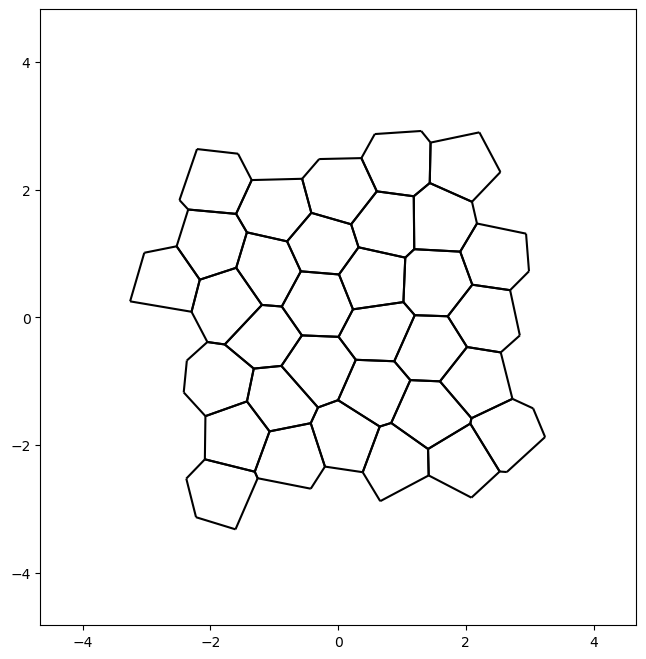

In [ ]:
# plot the initial condition

fig = plt.figure(figsize=(8,8))

meshes_simulated[0].cellplot()
#mesh_initial.triplot(): 

plt.gca().set_aspect("equal", adjustable="box");
plt.xlim([-property_dict["bdry_x"]-.5, property_dict["bdry_x"]+.5])
plt.ylim([-property_dict["bdry_y"]-.5, property_dict["bdry_y"]+.5])

<IPython.core.display.Javascript object>


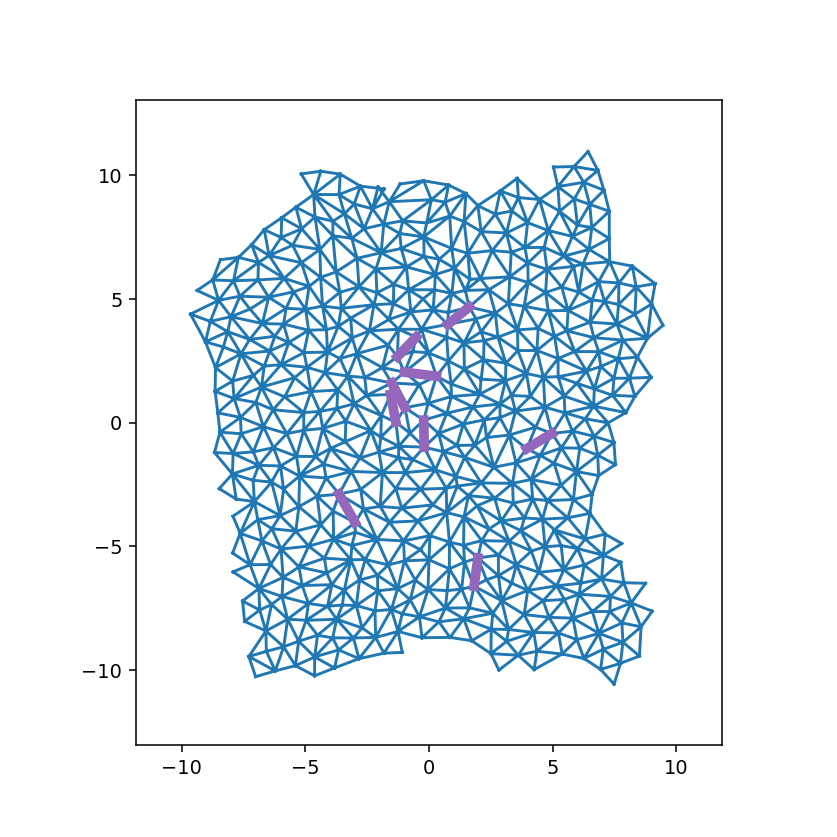

interactive(children=(IntSlider(value=149, description='i', max=299), FloatSlider(value=12.38079035184818, des…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
    
# fix the arguments which you do not need to tune with widgets.fixed

bdry_x, bdry_y = (property_dict["bdry_x"], property_dict["bdry_y"])

widgets.interact(drs.plot_mesh, i=(0, len(meshes_simulated)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(None),
                 edge_colors=widgets.fixed(None),
                 cell_colors=widgets.fixed(None),
                 mesh_series=widgets.fixed(meshes_simulated),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );


In [ ]:
%matplotlib inline

### Plotting tissue extension

In [ ]:
#| export

def get_tissue_extension(meshes, sigma=2, q=0.9, log=True, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)
                          ] for mesh in meshes[1:]])

    delta = np.quantile(centroids, axis=1, q=q)-np.quantile(centroids, axis=1, q=1-q,)
    delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
    delta_smooth /= delta_smooth[0]
    if log:
        delta_log = np.log(delta_smooth)
        return delta_log
    return delta_smooth

In [ ]:
delta_smooth = get_tissue_extension(meshes_simulated)
time = np.arange(delta_smooth.shape[0])*15/100

Text(0, 0.5, 'x-fold change')

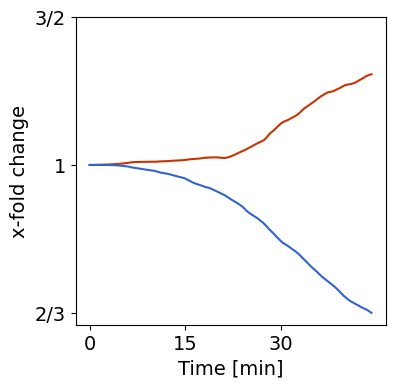

In [ ]:
fig = plt.figure(figsize=(4, 4))

plt.plot(time, delta_smooth[:,0], color='#ca3300ff', label="Length (AP)")
plt.plot(time, delta_smooth[:,1], color='#3163ceff', label="Width (DV)")

plt.yticks([np.log(2/3), 0, np.log(3/2)], ["2/3", 1, "3/2"], fontsize=14);
#plt.ylim([np.log(.5), np.log(1.7)])
plt.xticks([0, 15, 30], fontsize=14)

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('x-fold change', fontsize=14)

In [ ]:
# need longer simulation times if I start with weak anisotropy!

## Full phase diagram simulations

Use joblib

In [ ]:
strains = np.array([0, 0.012, 0.024, 0.0465, 0.088])
etas = np.array([0.5, 0.6, 0.7, 0.8, 0.9]) # to start with.

In [ ]:
#| export

from joblib import Parallel, delayed

In [ ]:
n_steps = 0
initial_strain = strains[3]
run_id = "backend_test"

In [ ]:
# run simulation

Parallel(n_jobs=4, backend="multiprocessing")(delayed(run_phase_diagm_sim)( # multiprocessing prints the progress
    eta=eta, initial_strain=initial_strain,
    n_steps=n_steps, 
    save=True, run_id=run_id, keep_in_memory=False)
    for eta in [0.5, 0.6, 0.7, 0.8,])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_20153/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)
/tmp/ipykernel_20153/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)
/tmp/ipykernel_20153/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)
/tmp/ipykernel_20153/2703963511.py:40: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(4*sigma**2-distance_perp**2)


KeyboardInterrupt: 

### Random intercalation simulation

Side note - how many intercalations are required to make a tissue disordered, if they are randomly distributed?

In [ ]:
mesh_initial = dln.get_tri_hemesh(nx=31, ny=41, noise=0.1)

len(mesh_initial.vertices)

851

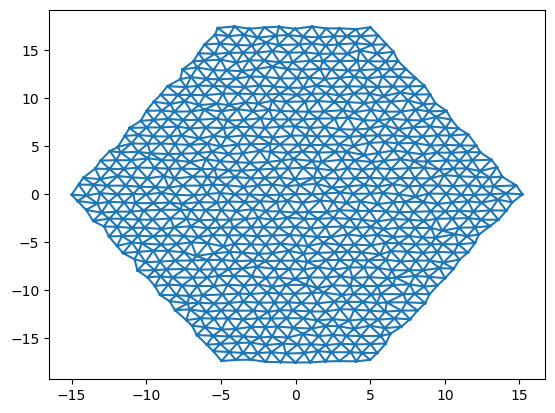

In [ ]:
mesh_initial.triplot()

In [ ]:
mesh = deepcopy(mesh_initial)

tries = 200 #2*len(mesh_initial.vertices)

for i in range(tries):
    he = mesh.hes[np.random.choice(len(mesh.hes))]
    if not he.is_bdry():
        try:
            mesh.flip_edge(he._heid)
        except ValueError:
            continue

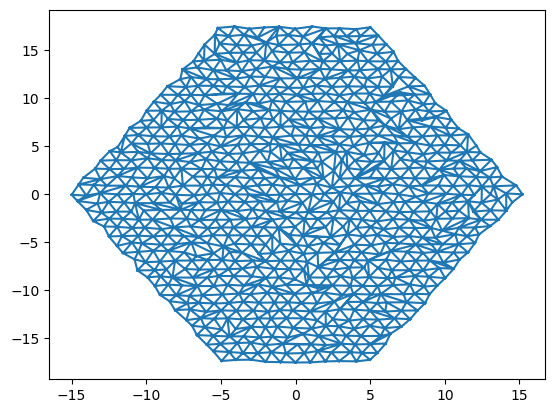

In [ ]:
mesh.triplot() # self-intersections if lots of flips??
# For low T1 numbers, like 1/4 number of cells, I get distribution that looks like random Delaunay already
# in terms of connectivity. with some asymetry and more pentagons than heptagons.

In [ ]:
# Gibson et al Markov chain: 28.9% pentagons, 46.4% hexagons, 20.8% heptagons

In [ ]:
vals = get_valences(mesh)

vals

{4: 0.048, 5: 0.23, 6: 0.469, 7: 0.185, 8: 0.056}

<BarContainer object of 5 artists>

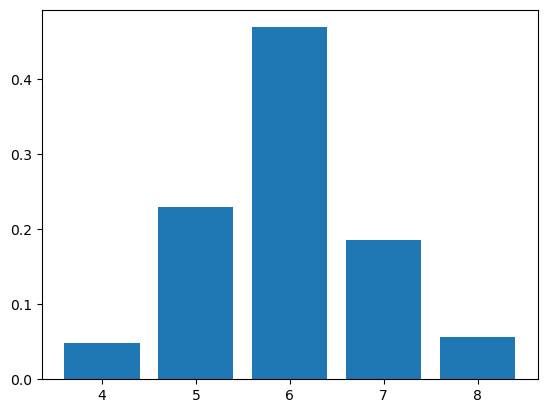

In [ ]:
keys = np.arange(4, 9)
plt.bar(keys, [vals[x] for x in keys])